In [1]:
# importing libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import warnings

%config InlineBackend.figure_format='retina'
warnings.filterwarnings("ignore")

/home/lac-user/Madhura/ANACONDA_FOLDER/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# defining functions

def Get_Feature_Importances(pipeline):
    feature_names = pipeline.named_steps['features'].transformer_list[0][1].named_steps['vectorizer'].get_feature_names()
    feature_names.extend(['word_count', 'char_count', 'word_density', 'total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks' ,'num_unique_words', 'words_vs_unique'])
    #print(len(feature_names))
    
    coefficients = pipeline[1].coef_

    importances = []
    for coef in coefficients:
        importances.append(list(coefficients.A[0]))
    importances = importances[0]
    #print(len(importances))
    #print(importances)
    
    feature_importances = dict()
    for i in range(len(feature_names)):
        feature_importances[feature_names[i]] = importances[i]
        #print(importances[i])

    #print(len(feature_importances))
    #print(feature_importances)
    
    return feature_importances

def Plot_Feature_Importances(feature_importances, top_features=10):
    top_positive_coefficients = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:top_features])
    top_negative_coefficients = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=False)[:top_features])
    top_coefficients = {**top_positive_coefficients , **top_negative_coefficients}
    top_coefficients = dict(sorted(top_coefficients.items(), key=lambda x: x[1], reverse=False))
    #type(top_coefficients)
    #top_coefficients

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in top_coefficients.values()]
    plt.bar(np.arange(2 * top_features)+1, top_coefficients.values(), color=colors)
    feature_names = list(top_coefficients.keys())
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names, rotation=60, ha='right')
    plt.show()

In [3]:
# read the data

df = pd.read_csv('sampdf_feat.csv')
df.shape

(54870, 19)

In [4]:
subdf = df[df['toxic']==1]
subdf.shape

(21383, 19)

In [5]:
categories = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
# Create X and y dataframe

X = subdf.loc[:, ['cleaned_comment_text', 'word_count', 'char_count', 'word_density', 'total_length',
               'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_unique_words', 'words_vs_unique'
               ]]
y = subdf[categories]

In [7]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (17106, 10)
y_train: (17106, 5)
X_test: (4277, 10)
y_test: (4277, 5)


In [8]:
# define classes for selecting features

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [9]:
# creating separate Pipelines for each feature

word_count =  Pipeline([
                ('selector', NumberSelector(key='word_count')),
                ('standard', StandardScaler())
            ])

word_count.fit_transform(X_train)

char_count =  Pipeline([
                ('selector', NumberSelector(key='char_count')),
                ('standard', StandardScaler())
            ])

char_count.fit_transform(X_train)

word_density =  Pipeline([
                ('selector', NumberSelector(key='word_density')),
                ('standard', StandardScaler())
            ])

word_density.fit_transform(X_train)

total_length =  Pipeline([
                ('selector', NumberSelector(key='total_length')),
                ('standard', StandardScaler())
            ])

total_length.fit_transform(X_train)

capitals =  Pipeline([
                ('selector', NumberSelector(key='capitals')),
                ('standard', StandardScaler())
            ])

capitals.fit_transform(X_train)

caps_vs_length =  Pipeline([
                ('selector', NumberSelector(key='caps_vs_length')),
                ('standard', StandardScaler())
            ])

caps_vs_length.fit_transform(X_train)

num_exclamation_marks =  Pipeline([
                ('selector', NumberSelector(key='num_exclamation_marks')),
                ('standard', StandardScaler())
            ])

num_exclamation_marks.fit_transform(X_train)

num_unique_words =  Pipeline([
                ('selector', NumberSelector(key='num_unique_words')),
                ('standard', StandardScaler())
            ])

num_unique_words.fit_transform(X_train)

words_vs_unique =  Pipeline([
                ('selector', NumberSelector(key='words_vs_unique')),
                ('standard', StandardScaler())
            ])

words_vs_unique.fit_transform(X_train)

array([[ 0.3433602 ],
       [-4.5823279 ],
       [ 0.17315415],
       ...,
       [ 0.25732198],
       [ 0.25732198],
       [-0.25890734]])

##### USING TF-IDF VECTORIZER

In [10]:
# TF-IDF vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', TfidfVectorizer(stop_words='english'))
        ])

text.fit_transform(X_train)

<17106x30934 sparse matrix of type '<class 'numpy.float64'>'
	with 245326 stored elements in Compressed Sparse Row format>

In [11]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<17106x30943 sparse matrix of type '<class 'numpy.float64'>'
	with 399280 stored elements in Compressed Sparse Row format>

In [12]:
# defining the models

range_C = [0.1, 0.5, 1.0, 2.0, 5.0]
pipelines = []

for C in range_C:
    SVM = svm.SVC(C=C, kernel='linear')

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', SVM),
    ])
    
    pipelines.append(pipeline)

In [13]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [14]:
# train, predict and evaluate on training and test data

for i in range(len(pipelines)):
    
    print('Calculating for C = ', range_C[i])
    
    train_TP = list()
    train_FP = list()
    train_FN = list()
    train_TN = list()
    train_accuracy = list()
    train_precision = list()
    train_recall = list()
    train_f1_score = list()
    
    test_TP = list()
    test_FP = list()
    test_FN = list()
    test_TN = list()
    test_accuracy = list()
    test_precision = list()
    test_recall = list()
    test_f1_score = list()
    
    for category in categories:
        
        print('\t... Processing {}'.format(category))
        
        # train the model
        print('\tTraining...')
        pipelines[i].fit(X_train, y_train[category])

        print('\t\tCalculating Training Metrics for C = ', range_C[i])
        train_pred = pipelines[i].predict(X_train)
        
        cm = confusion_matrix(y_train[category], train_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        train_TP.append(TP_i)
        train_FP.append(FP_i)
        train_FN.append(FN_i)
        train_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        train_accuracy.append(accuracy_i)
        
        print('\t\tCalculating Testing Metrics for C = ', range_C[i])
        test_pred = pipelines[i].predict(X_test)
        
        cm = confusion_matrix(y_test[category], test_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        test_TP.append(TP_i)
        test_FP.append(FP_i)
        test_FN.append(FN_i)
        test_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        test_accuracy.append(accuracy_i)
        
    train_avg_accuracy = np.average(train_accuracy)
    train_precision = sum(train_TP) / (sum(train_TP) + sum(train_FP))
    train_recall = sum(train_TP) / (sum(train_TP) + sum(train_FN))
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    test_avg_accuracy = np.average(test_accuracy)
    test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
    test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*train_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*train_precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*train_recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*train_f1_score, 2)
    
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*test_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*test_precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*test_recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*test_f1_score, 2)
    
display(summary)

Calculating for C =  0.1
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing threat
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing insult
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing identity_hate
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
Calculating for C =  0.5
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.5
		Calculating Testing Metrics for C =  0.5
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.5
		Calculating Testing Metrics for C =  0.5
	... Processing threat
	Training...
		Calculating Training Metrics f

,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,86.17,88.95,51.59,65.3,85.78,85.44,50.99,63.86
1,0.5,90.33,89.74,69.65,78.43,87.08,80.92,62.28,70.38
2,1,93,91.31,79.87,85.21,87.11,78.21,66.13,71.66
3,2,95.44,92.68,88.97,90.79,86.97,75.91,69.01,72.3
4,5,97.16,94.52,94.21,94.36,85.65,71.7,68.99,70.32


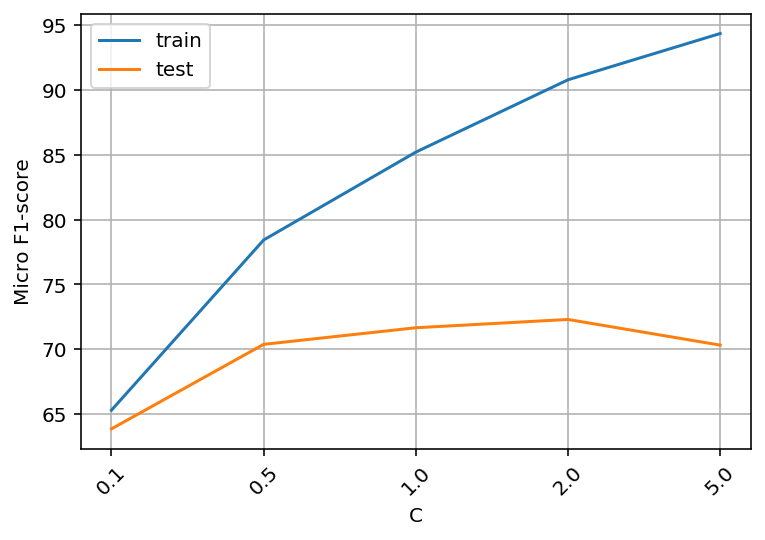

In [15]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the model starts to overfit and test score remains constant after C = 2.0, we will select 2.0 for C.

Calculating for C = 2.0
	... Processing severe_toxic
	Training...


array([[3808,   73],
       [ 297,   99]])

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3881
           1       0.58      0.25      0.35       396

    accuracy                           0.91      4277
   macro avg       0.75      0.62      0.65      4277
weighted avg       0.90      0.91      0.90      4277



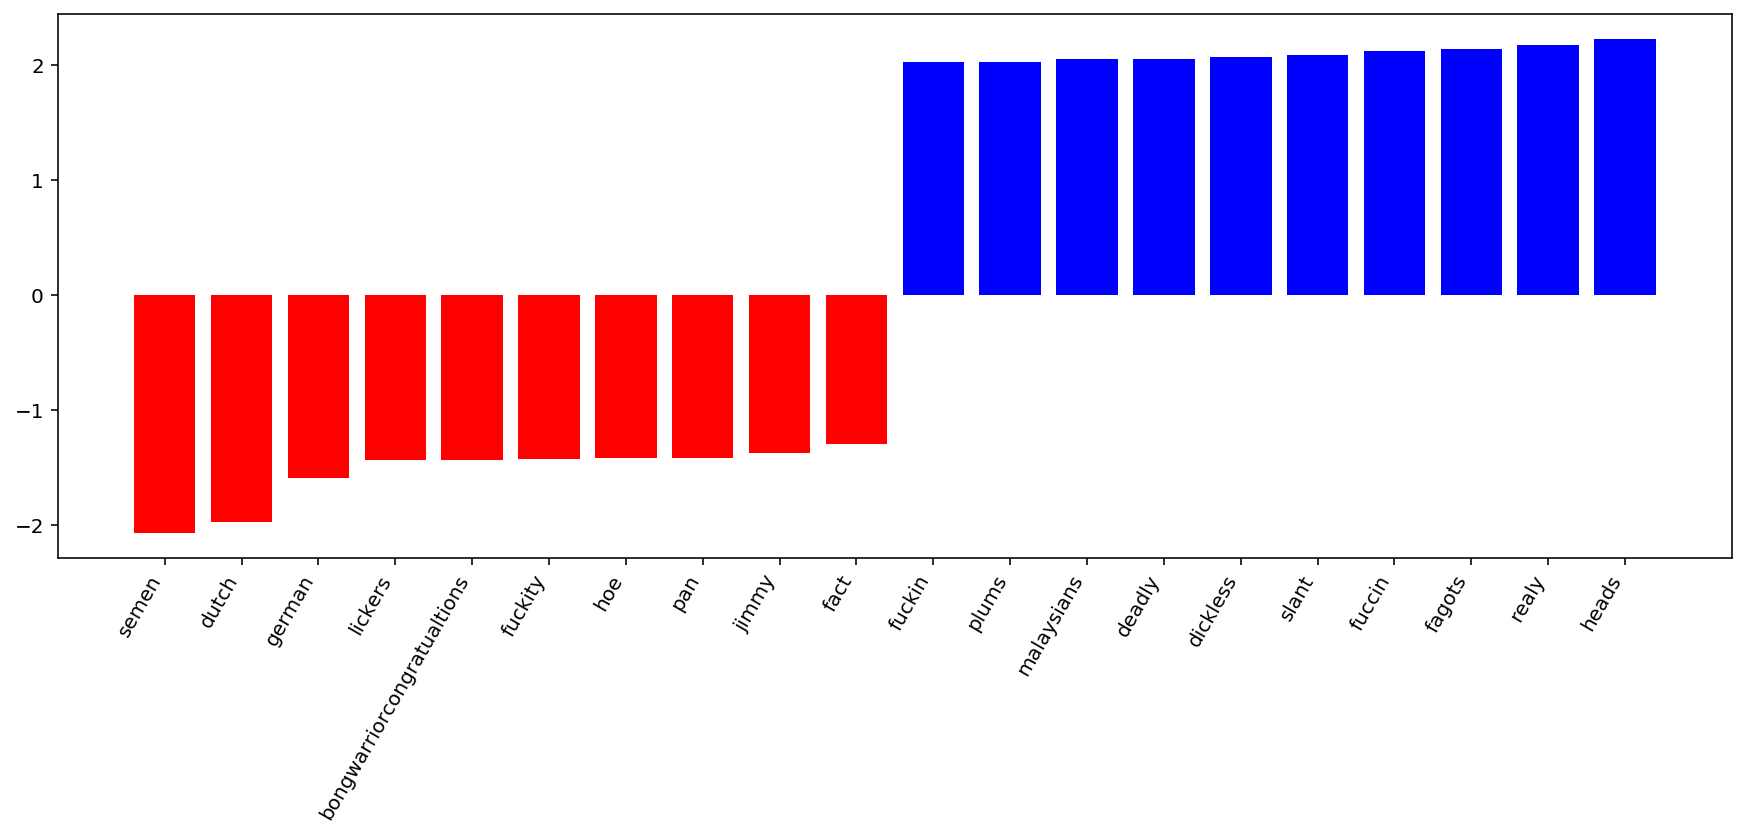

	... Processing obscene
	Training...


array([[1640,  381],
       [ 460, 1796]])

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      2021
           1       0.82      0.80      0.81      2256

    accuracy                           0.80      4277
   macro avg       0.80      0.80      0.80      4277
weighted avg       0.80      0.80      0.80      4277



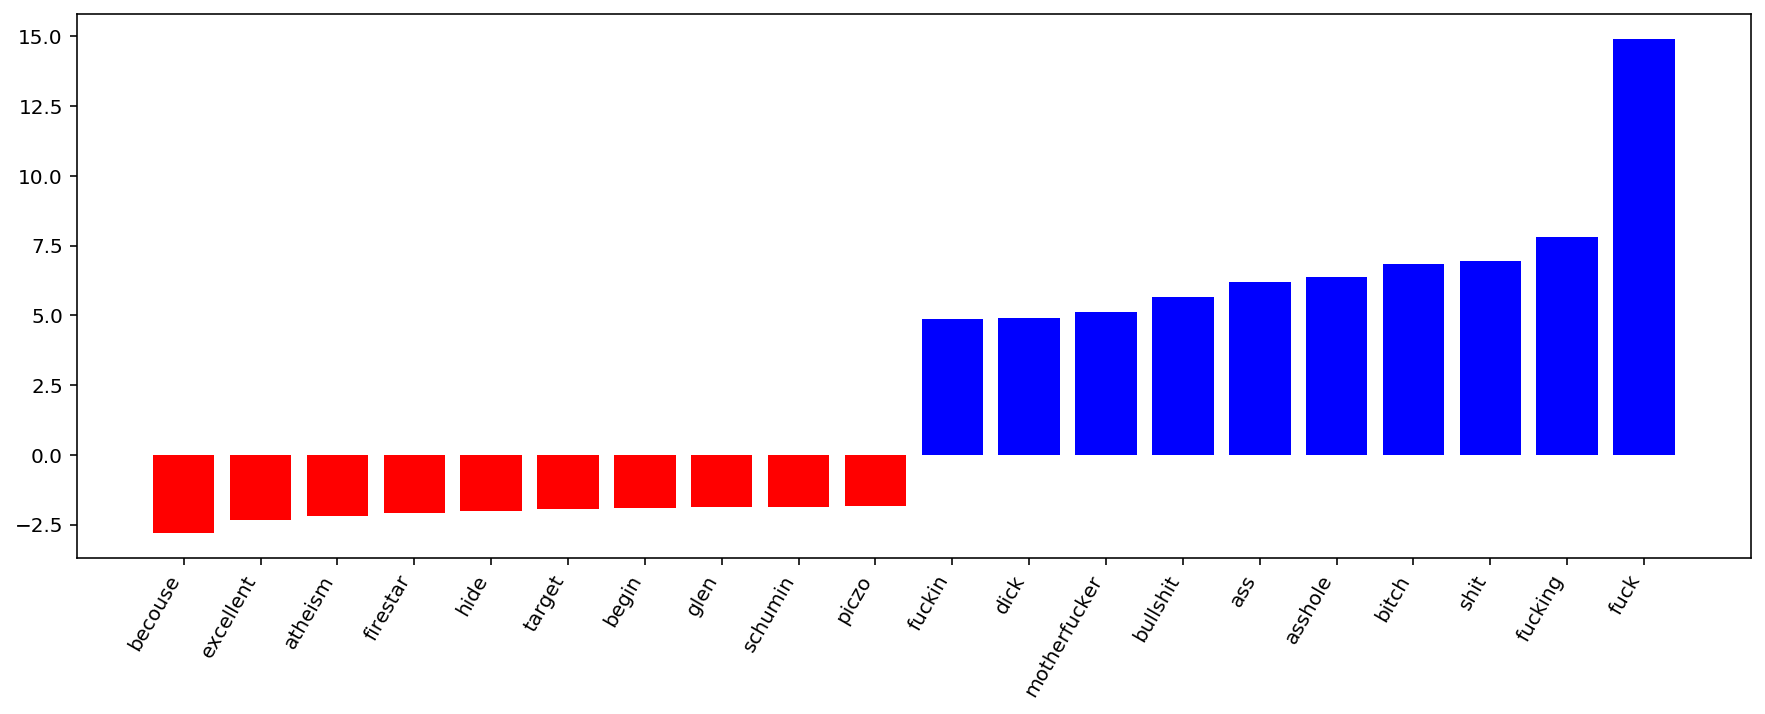

	... Processing threat
	Training...


array([[4130,   30],
       [  77,   40]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4160
           1       0.57      0.34      0.43       117

    accuracy                           0.97      4277
   macro avg       0.78      0.67      0.71      4277
weighted avg       0.97      0.97      0.97      4277



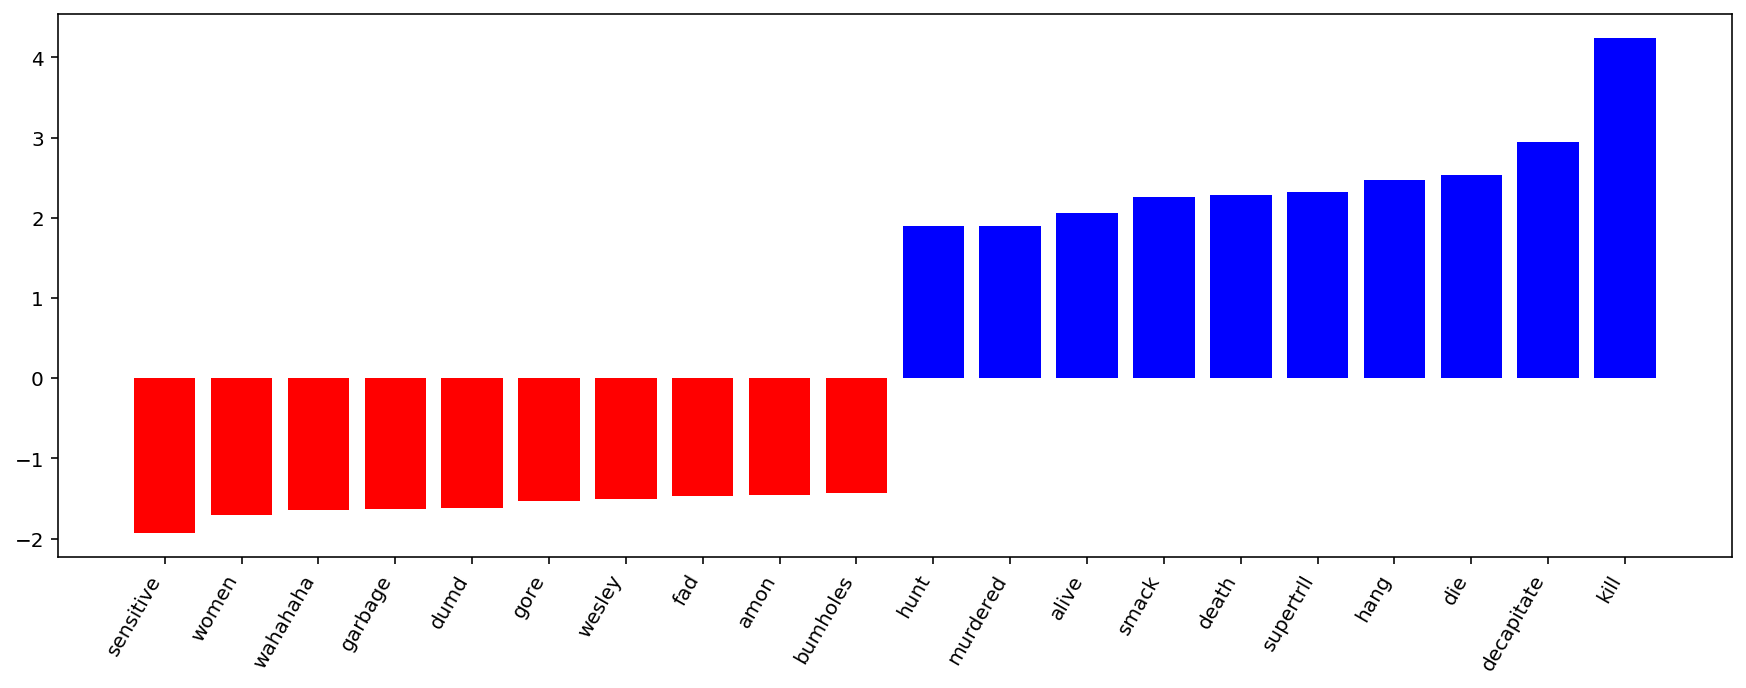

	... Processing insult
	Training...


array([[1582,  577],
       [ 605, 1513]])

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      2159
           1       0.72      0.71      0.72      2118

    accuracy                           0.72      4277
   macro avg       0.72      0.72      0.72      4277
weighted avg       0.72      0.72      0.72      4277



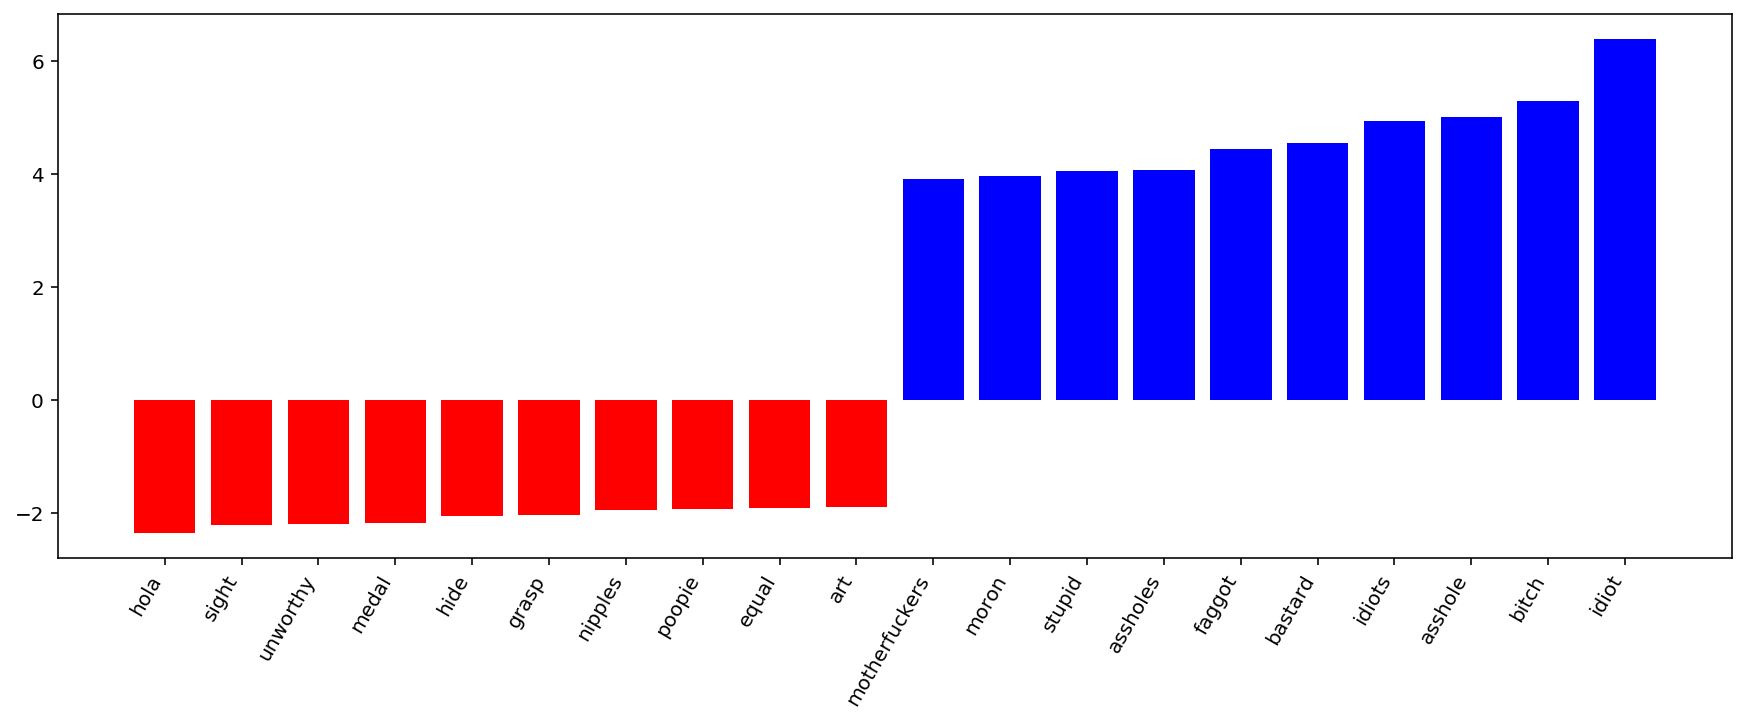

	... Processing identity_hate
	Training...


array([[3801,   93],
       [ 194,  189]])

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3894
           1       0.67      0.49      0.57       383

    accuracy                           0.93      4277
   macro avg       0.81      0.73      0.77      4277
weighted avg       0.93      0.93      0.93      4277



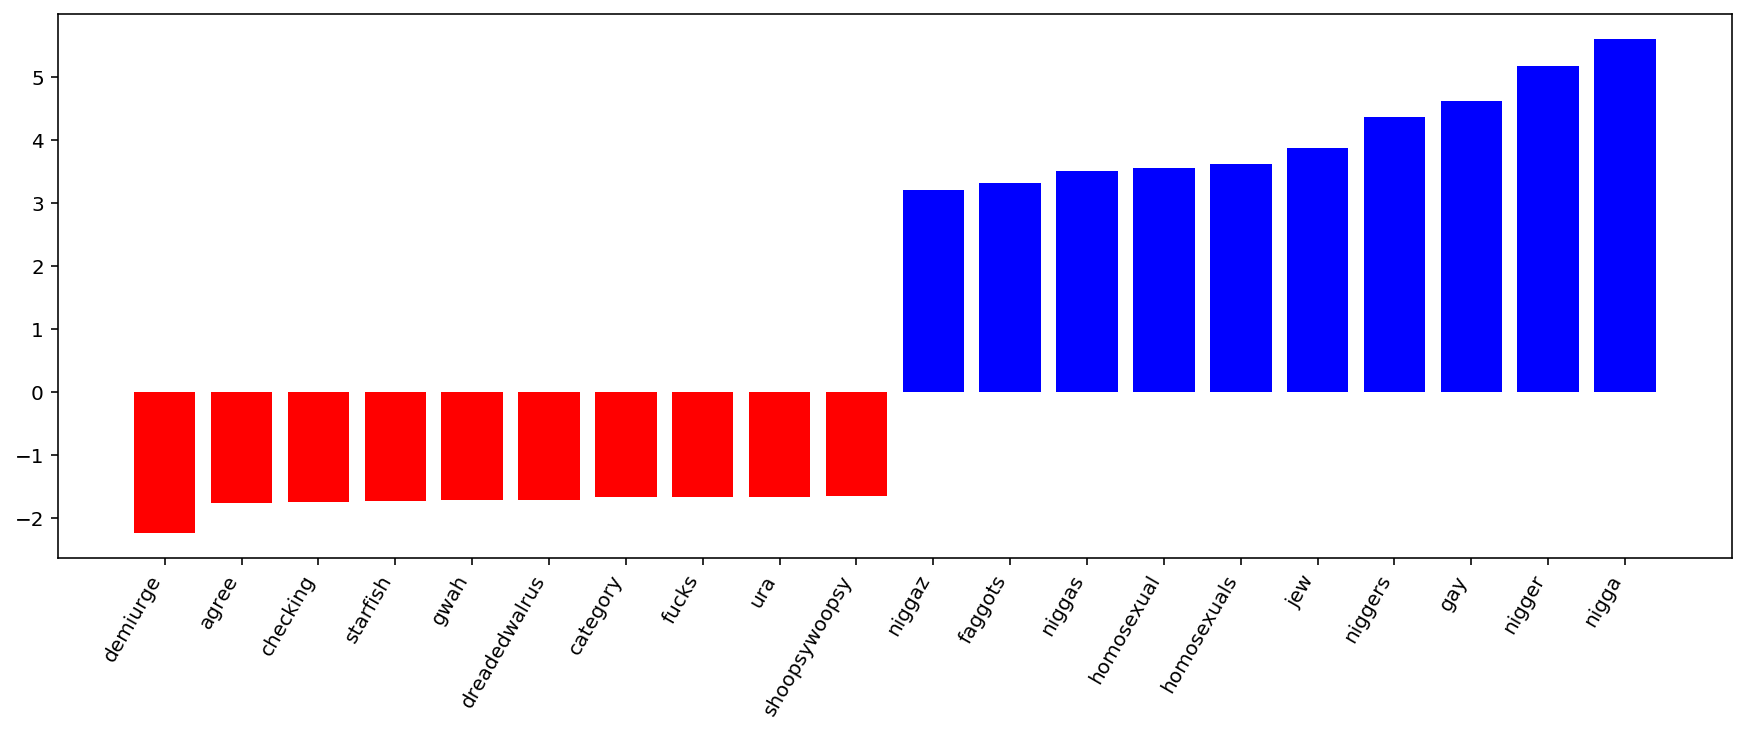


Micro Precision: 75.91%
Micro Recall: 69.01%
Micro F1-score: 72.3%
Average Accuracy: 86.97%


In [14]:
print('Calculating for C = 2.0')

test_TP = list()
test_FP = list()
test_FN = list()
test_TN = list()
test_accuracy = list()
test_precision = list()
test_recall = list()
test_f1_score = list()

for category in categories:
    print('\t... Processing {}'.format(category))

    # train the model
    print('\tTraining...')
    pipelines[3].fit(X_train, y_train[category])
    test_pred = pipelines[3].predict(X_test)

    display(confusion_matrix(y_test[category], test_pred))
    print(classification_report(y_test[category], test_pred))
    
    cm = confusion_matrix(y_test[category], test_pred)
    TN_i = cm[0][0]
    FP_i = cm[0][1]
    FN_i = cm[1][0]
    TP_i = cm[1][1]

    test_TP.append(TP_i)
    test_FP.append(FP_i)
    test_FN.append(FN_i)
    test_TN.append(TN_i)

    accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
    test_accuracy.append(accuracy_i)
    
    # feature importance
    feature_importances = Get_Feature_Importances(pipelines[3])
    Plot_Feature_Importances(feature_importances) 
    
    # saving the model
    filename = 'TFIDF_SVM_Level_2_' + str(category) + '.joblib'
    joblib.dump(pipelines[3], filename)

test_avg_accuracy = np.average(test_accuracy)
test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)

print("\nMicro Precision: {}%".format(round(100*test_precision, 2)))
print("Micro Recall: {}%".format(round(100*test_recall, 2)))
print("Micro F1-score: {}%".format(round(100*test_f1_score, 2)))
print("Average Accuracy: {}%".format(round(100*test_avg_accuracy, 2)))

##### USING BINARY VECTORIZER

In [15]:
# Binary vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False))
        ])

text.fit_transform(X_train)

<17106x30934 sparse matrix of type '<class 'numpy.float64'>'
	with 245326 stored elements in Compressed Sparse Row format>

In [16]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<17106x30943 sparse matrix of type '<class 'numpy.float64'>'
	with 399280 stored elements in Compressed Sparse Row format>

In [17]:
# defining the models

range_C = [0.1, 0.5, 1.0, 2.0, 5.0]
pipelines = []

for C in range_C:
    SVM = svm.SVC(C=C, kernel='linear')

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', SVM),
    ])
    
    pipelines.append(pipeline)

In [18]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [19]:
# train, predict and evaluate on training and test data

for i in range(len(pipelines)):
    
    print('Calculating for C = ', range_C[i])
    
    train_TP = list()
    train_FP = list()
    train_FN = list()
    train_TN = list()
    train_accuracy = list()
    train_precision = list()
    train_recall = list()
    train_f1_score = list()
    
    test_TP = list()
    test_FP = list()
    test_FN = list()
    test_TN = list()
    test_accuracy = list()
    test_precision = list()
    test_recall = list()
    test_f1_score = list()
    
    for category in categories:
        
        print('\t... Processing {}'.format(category))
        
        # train the model
        print('\tTraining...')
        pipelines[i].fit(X_train, y_train[category])

        print('\t\tCalculating Training Metrics for C = ', range_C[i])
        train_pred = pipelines[i].predict(X_train)
        
        cm = confusion_matrix(y_train[category], train_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        train_TP.append(TP_i)
        train_FP.append(FP_i)
        train_FN.append(FN_i)
        train_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        train_accuracy.append(accuracy_i)
        
        print('\t\tCalculating Testing Metrics for C = ', range_C[i])
        test_pred = pipelines[i].predict(X_test)
        
        cm = confusion_matrix(y_test[category], test_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        test_TP.append(TP_i)
        test_FP.append(FP_i)
        test_FN.append(FN_i)
        test_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        test_accuracy.append(accuracy_i)
        
    train_avg_accuracy = np.average(train_accuracy)
    train_precision = sum(train_TP) / (sum(train_TP) + sum(train_FP))
    train_recall = sum(train_TP) / (sum(train_TP) + sum(train_FN))
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    test_avg_accuracy = np.average(test_accuracy)
    test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
    test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*train_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*train_precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*train_recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*train_f1_score, 2)
    
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*test_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*test_precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*test_recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*test_f1_score, 2)
    
display(summary)

Calculating for C =  0.1
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing threat
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing insult
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing identity_hate
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
Calculating for C =  0.5
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.5
		Calculating Testing Metrics for C =  0.5
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.5
		Calculating Testing Metrics for C =  0.5
	... Processing threat
	Training...
		Calculating Training Metrics f

,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,91.32,88.49,75.38,81.41,87.36,79.36,65.83,71.96
1,0.5,95.82,93.61,89.53,91.53,86.87,75.38,69.41,72.27
2,1,97.13,95.3,93.21,94.24,86.38,73.34,70.27,71.77
3,2,97.83,96.19,95.15,95.67,85.55,71.02,69.85,70.43
4,5,98.33,96.96,96.39,96.67,84.65,68.5,69.85,69.17


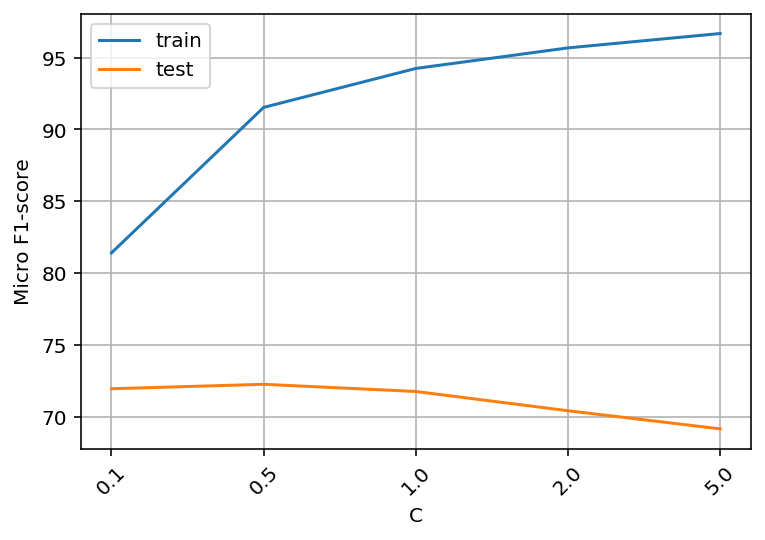

In [20]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the test score is highest at C = 0.5, we will select 0.5 for C.

Calculating for C = 0.5
	... Processing severe_toxic
	Training...


array([[3809,   72],
       [ 321,   75]])

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3881
           1       0.51      0.19      0.28       396

    accuracy                           0.91      4277
   macro avg       0.72      0.59      0.61      4277
weighted avg       0.88      0.91      0.89      4277



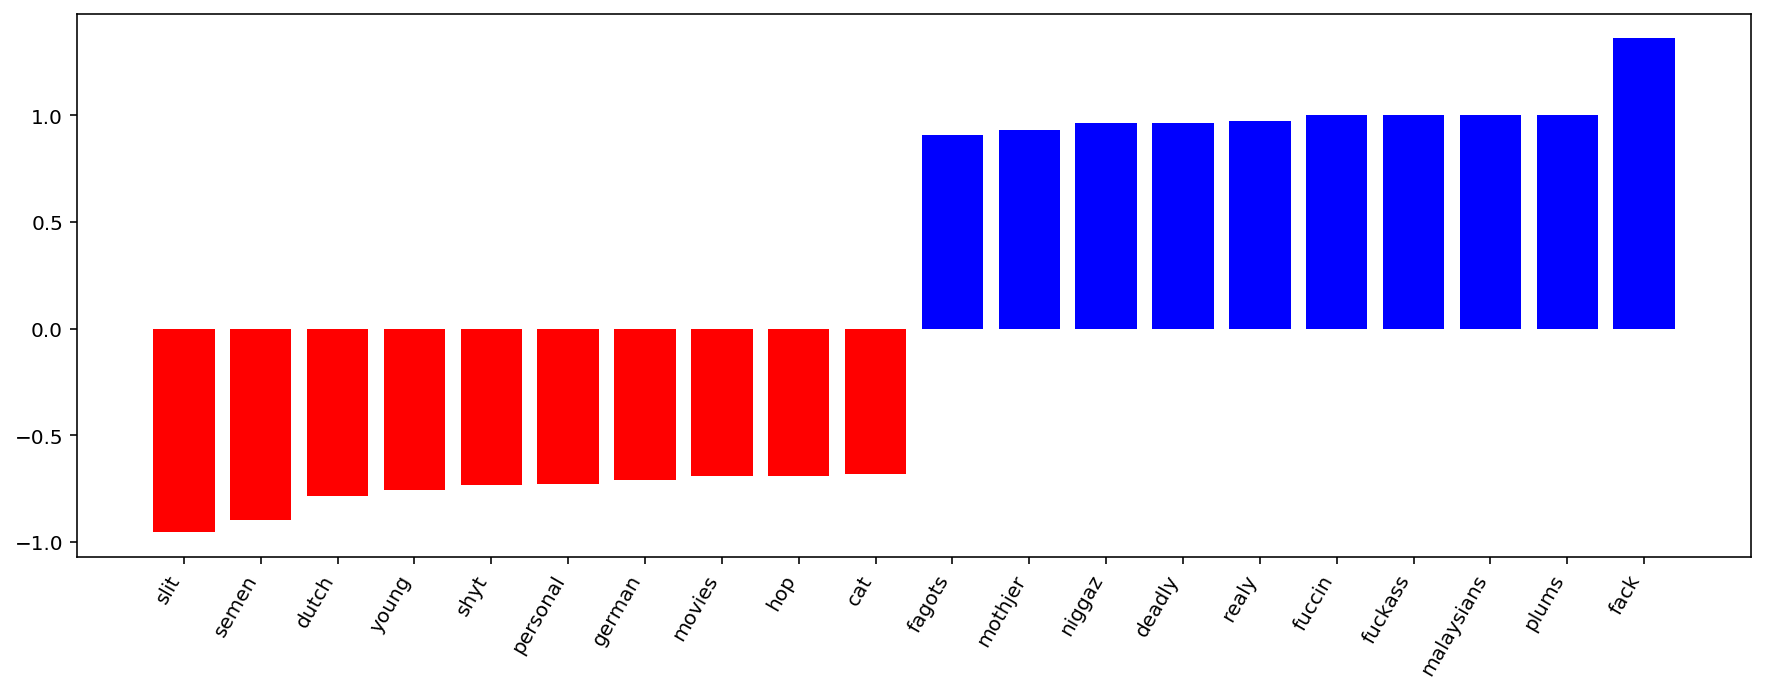

	... Processing obscene
	Training...


array([[1648,  373],
       [ 444, 1812]])

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2021
           1       0.83      0.80      0.82      2256

    accuracy                           0.81      4277
   macro avg       0.81      0.81      0.81      4277
weighted avg       0.81      0.81      0.81      4277



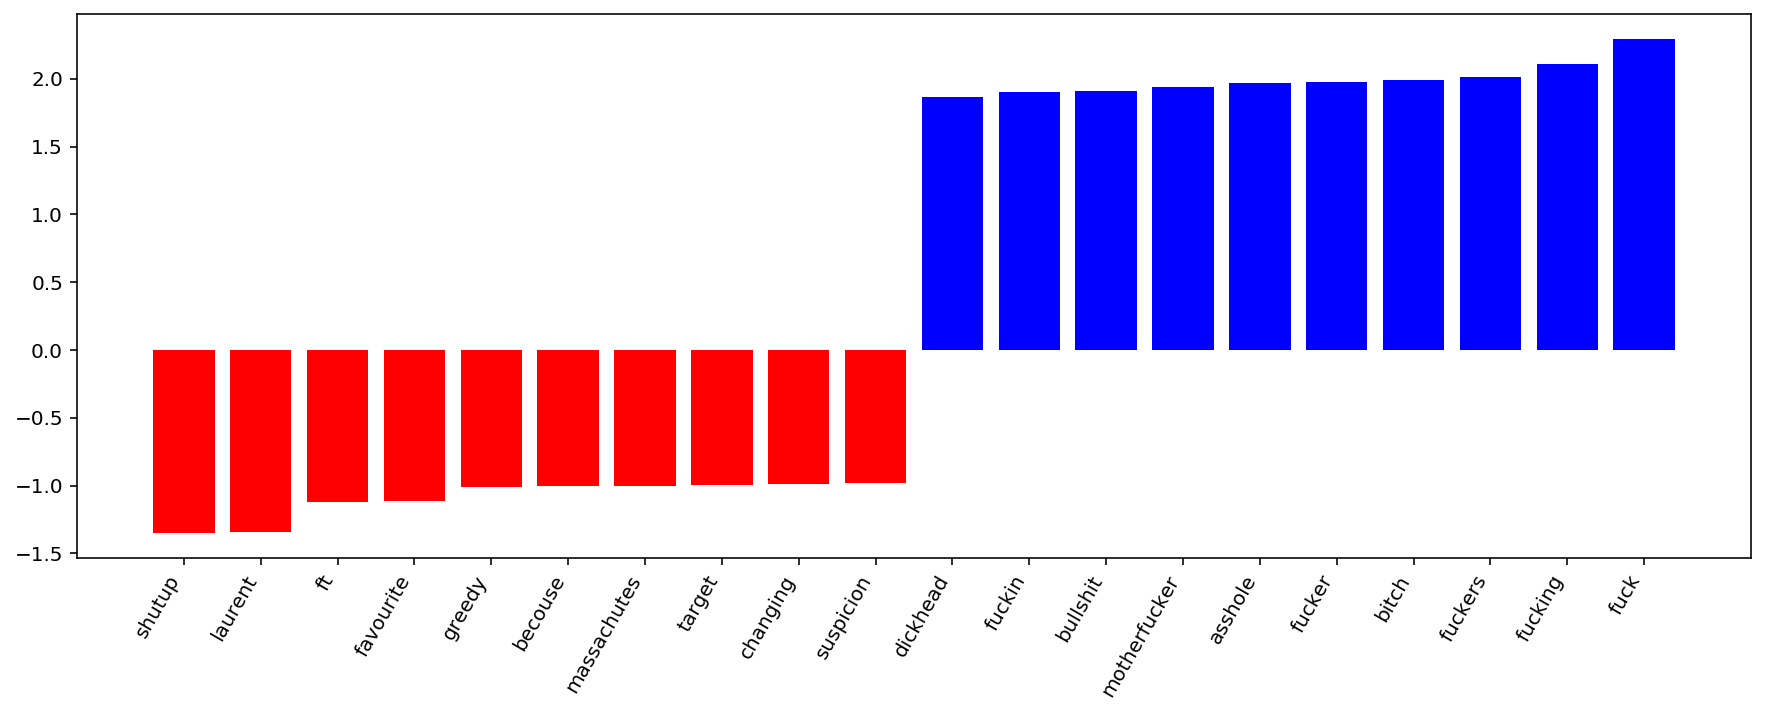

	... Processing threat
	Training...


array([[4114,   46],
       [  73,   44]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4160
           1       0.49      0.38      0.43       117

    accuracy                           0.97      4277
   macro avg       0.74      0.68      0.71      4277
weighted avg       0.97      0.97      0.97      4277



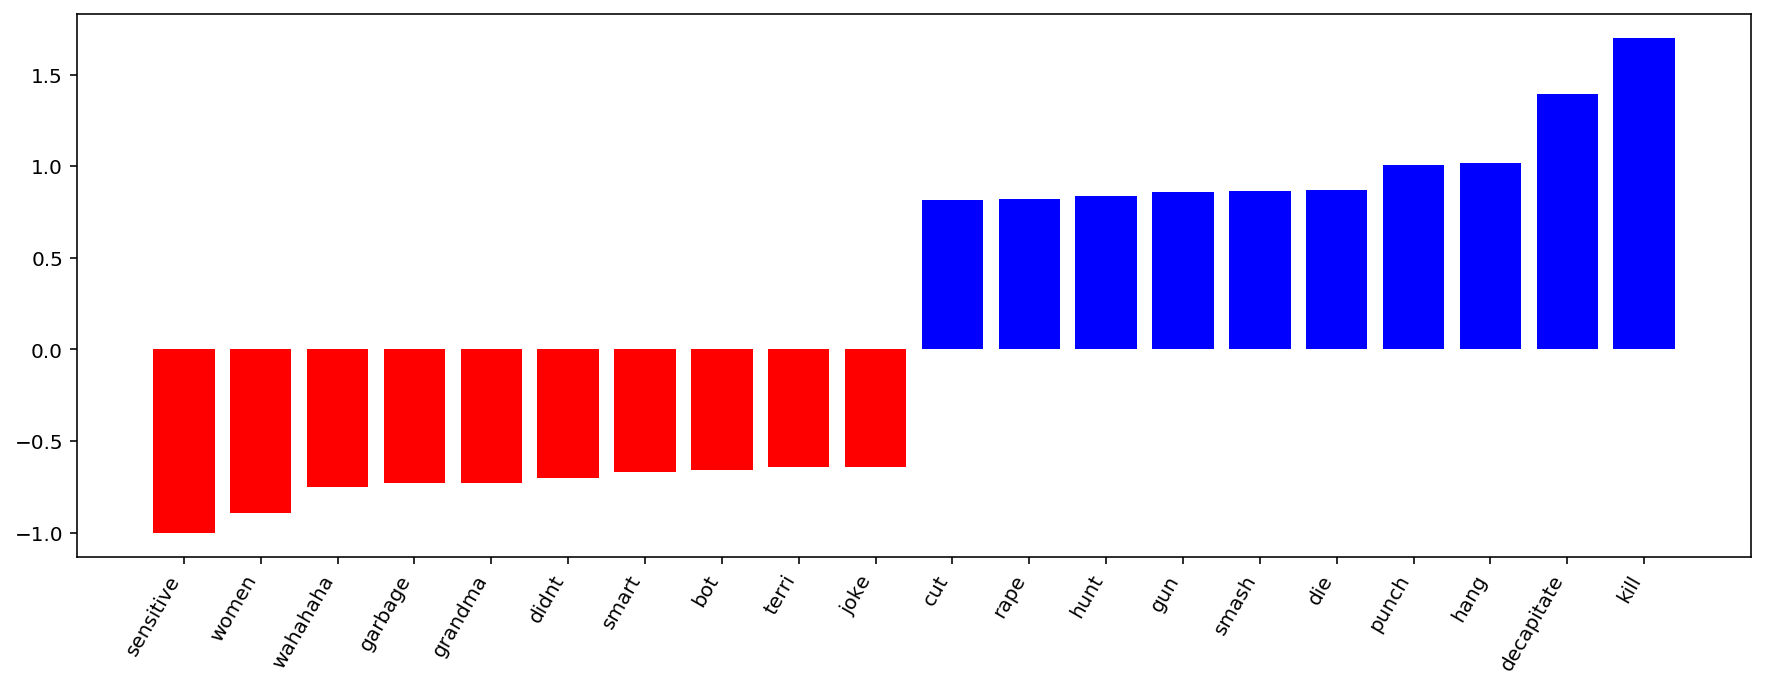

	... Processing insult
	Training...


array([[1586,  573],
       [ 599, 1519]])

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2159
           1       0.73      0.72      0.72      2118

    accuracy                           0.73      4277
   macro avg       0.73      0.73      0.73      4277
weighted avg       0.73      0.73      0.73      4277



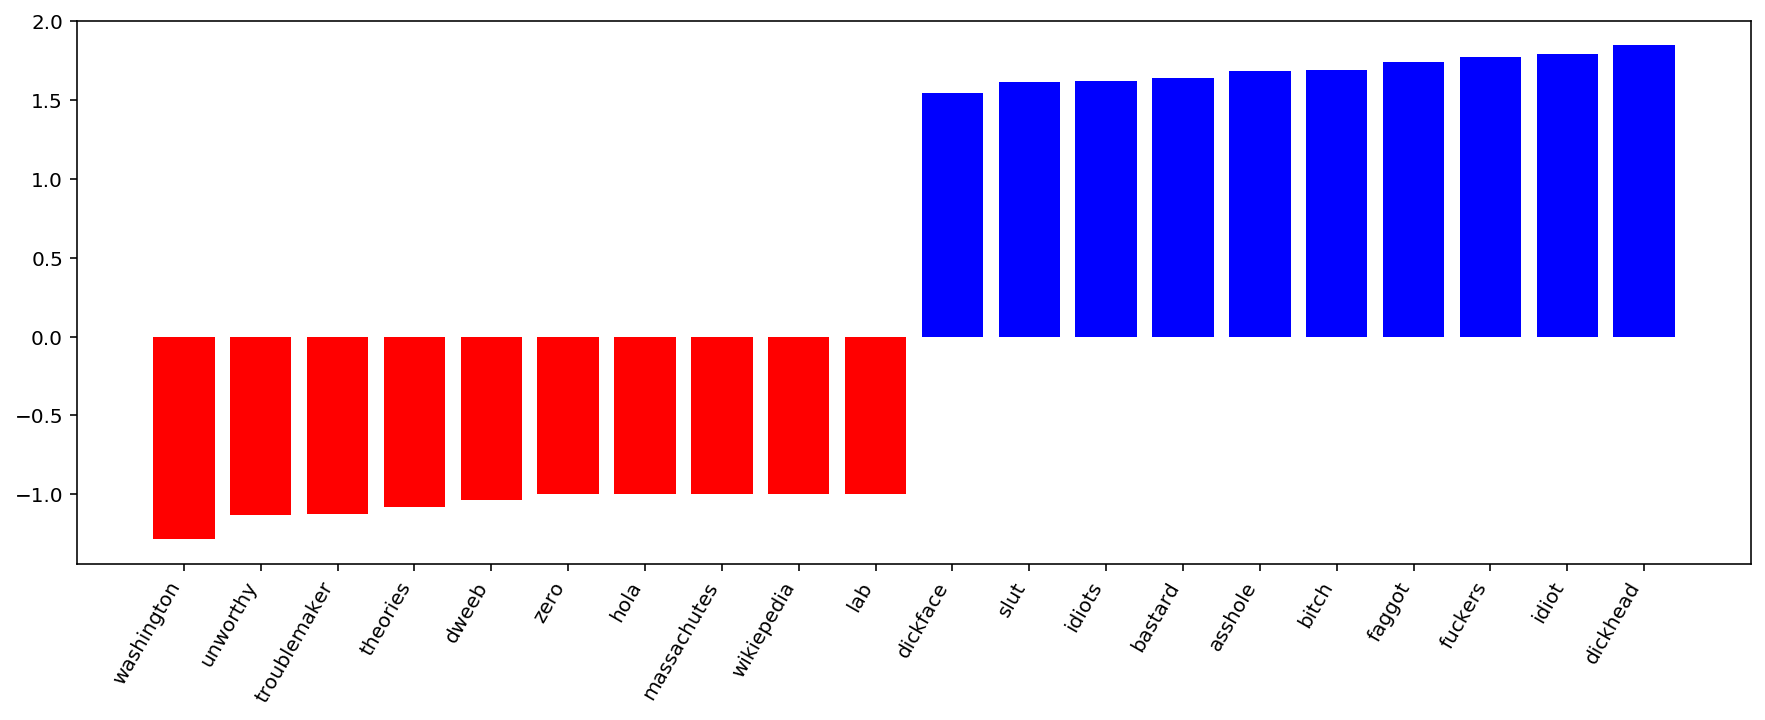

	... Processing identity_hate
	Training...


array([[3763,  131],
       [ 175,  208]])

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3894
           1       0.61      0.54      0.58       383

    accuracy                           0.93      4277
   macro avg       0.78      0.75      0.77      4277
weighted avg       0.92      0.93      0.93      4277



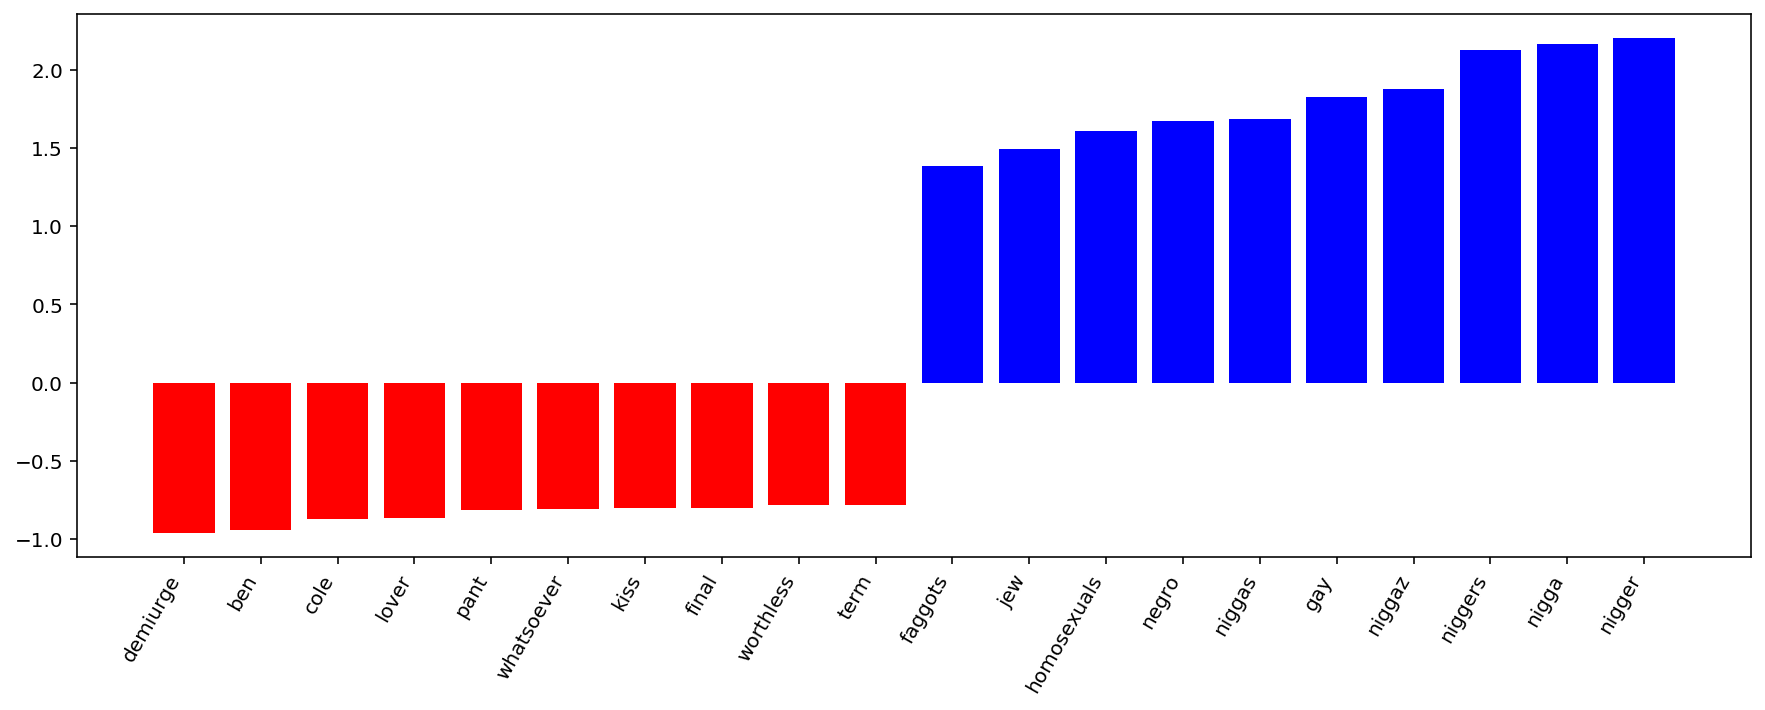


Micro Precision: 75.38%
Micro Recall: 69.41%
Micro F1-score: 72.27%
Average Accuracy: 86.87%


In [21]:
print('Calculating for C = 0.5')

test_TP = list()
test_FP = list()
test_FN = list()
test_TN = list()
test_accuracy = list()
test_precision = list()
test_recall = list()
test_f1_score = list()

for category in categories:
    print('\t... Processing {}'.format(category))

    # train the model
    print('\tTraining...')
    pipelines[1].fit(X_train, y_train[category])
    test_pred = pipelines[1].predict(X_test)

    display(confusion_matrix(y_test[category], test_pred))
    print(classification_report(y_test[category], test_pred))
    
    cm = confusion_matrix(y_test[category], test_pred)
    TN_i = cm[0][0]
    FP_i = cm[0][1]
    FN_i = cm[1][0]
    TP_i = cm[1][1]

    test_TP.append(TP_i)
    test_FP.append(FP_i)
    test_FN.append(FN_i)
    test_TN.append(TN_i)

    accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
    test_accuracy.append(accuracy_i)
    
    # feature importance
    feature_importances = Get_Feature_Importances(pipelines[1])
    Plot_Feature_Importances(feature_importances) 
    
    # saving the model
    filename = 'Binary_SVM_Level_2_' + str(category) + '.joblib'
    joblib.dump(pipelines[1], filename)

test_avg_accuracy = np.average(test_accuracy)
test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)

print("\nMicro Precision: {}%".format(round(100*test_precision, 2)))
print("Micro Recall: {}%".format(round(100*test_recall, 2)))
print("Micro F1-score: {}%".format(round(100*test_f1_score, 2)))
print("Average Accuracy: {}%".format(round(100*test_avg_accuracy, 2)))

##### USING COUNT VECTORIZER

In [10]:
# Count vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', CountVectorizer(stop_words='english'))
        ])

text.fit_transform(X_train)

<17106x30934 sparse matrix of type '<class 'numpy.int64'>'
	with 245326 stored elements in Compressed Sparse Row format>

In [11]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<17106x30943 sparse matrix of type '<class 'numpy.float64'>'
	with 399280 stored elements in Compressed Sparse Row format>

In [12]:
# defining the models

range_C = [0.1, 0.5, 1.0, 2.0, 5.0]
pipelines = []

for C in range_C:
    SVM = svm.SVC(C=C, kernel='linear')

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', SVM),
    ])
    
    pipelines.append(pipeline)

In [13]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [14]:
# train, predict and evaluate on training and test data

for i in range(len(pipelines)):
    
    print('Calculating for C = ', range_C[i])
    
    train_TP = list()
    train_FP = list()
    train_FN = list()
    train_TN = list()
    train_accuracy = list()
    train_precision = list()
    train_recall = list()
    train_f1_score = list()
    
    test_TP = list()
    test_FP = list()
    test_FN = list()
    test_TN = list()
    test_accuracy = list()
    test_precision = list()
    test_recall = list()
    test_f1_score = list()
    
    for category in categories:
        
        print('\t... Processing {}'.format(category))
        
        # train the model
        print('\tTraining...')
        pipelines[i].fit(X_train, y_train[category])

        print('\t\tCalculating Training Metrics for C = ', range_C[i])
        train_pred = pipelines[i].predict(X_train)
        
        cm = confusion_matrix(y_train[category], train_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        train_TP.append(TP_i)
        train_FP.append(FP_i)
        train_FN.append(FN_i)
        train_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        train_accuracy.append(accuracy_i)
        
        print('\t\tCalculating Testing Metrics for C = ', range_C[i])
        test_pred = pipelines[i].predict(X_test)
        
        cm = confusion_matrix(y_test[category], test_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        test_TP.append(TP_i)
        test_FP.append(FP_i)
        test_FN.append(FN_i)
        test_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        test_accuracy.append(accuracy_i)
        
    train_avg_accuracy = np.average(train_accuracy)
    train_precision = sum(train_TP) / (sum(train_TP) + sum(train_FP))
    train_recall = sum(train_TP) / (sum(train_TP) + sum(train_FN))
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    test_avg_accuracy = np.average(test_accuracy)
    test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
    test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*train_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*train_precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*train_recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*train_f1_score, 2)
    
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*test_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*test_precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*test_recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*test_f1_score, 2)
    
display(summary)

Calculating for C =  0.1
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing threat
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing insult
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing identity_hate
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
Calculating for C =  0.5
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.5
		Calculating Testing Metrics for C =  0.5
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.5
		Calculating Testing Metrics for C =  0.5
	... Processing threat
	Training...
		Calculating Training Metrics f

,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,90.87,90.62,71.19,79.74,85.85,77.82,59.58,67.49
1,0.5,95.19,94.72,85.73,90,85.05,72.36,63.62,67.71
2,1,96.51,95.9,90.04,92.87,84.17,69.35,64.06,66.6
3,2,97.28,96.77,92.31,94.49,83.6,67.13,65.5,66.31
4,5,97.84,97.32,94.01,95.64,82.75,64.53,66.6,65.55


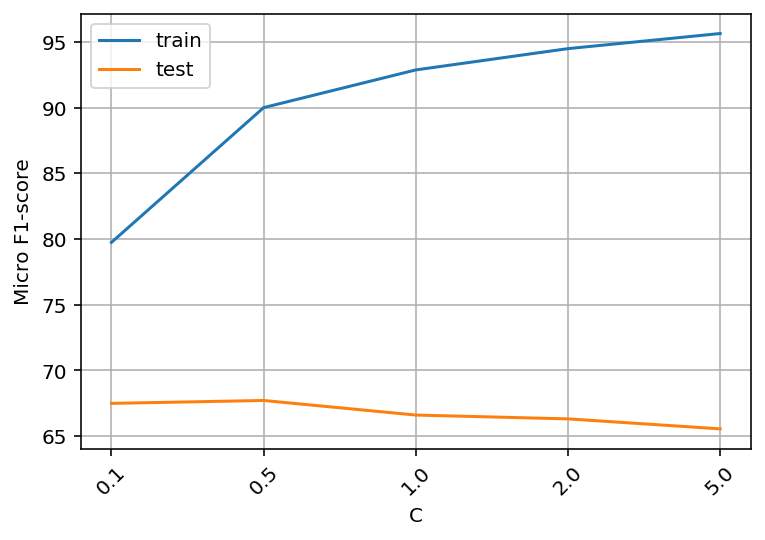

In [16]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the test score is highest at C = 0.5, we select 0.5 for C.

Calculating for C = 0.5
	... Processing severe_toxic
	Training...


array([[3795,   86],
       [ 334,   62]])

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3881
           1       0.42      0.16      0.23       396

    accuracy                           0.90      4277
   macro avg       0.67      0.57      0.59      4277
weighted avg       0.87      0.90      0.88      4277



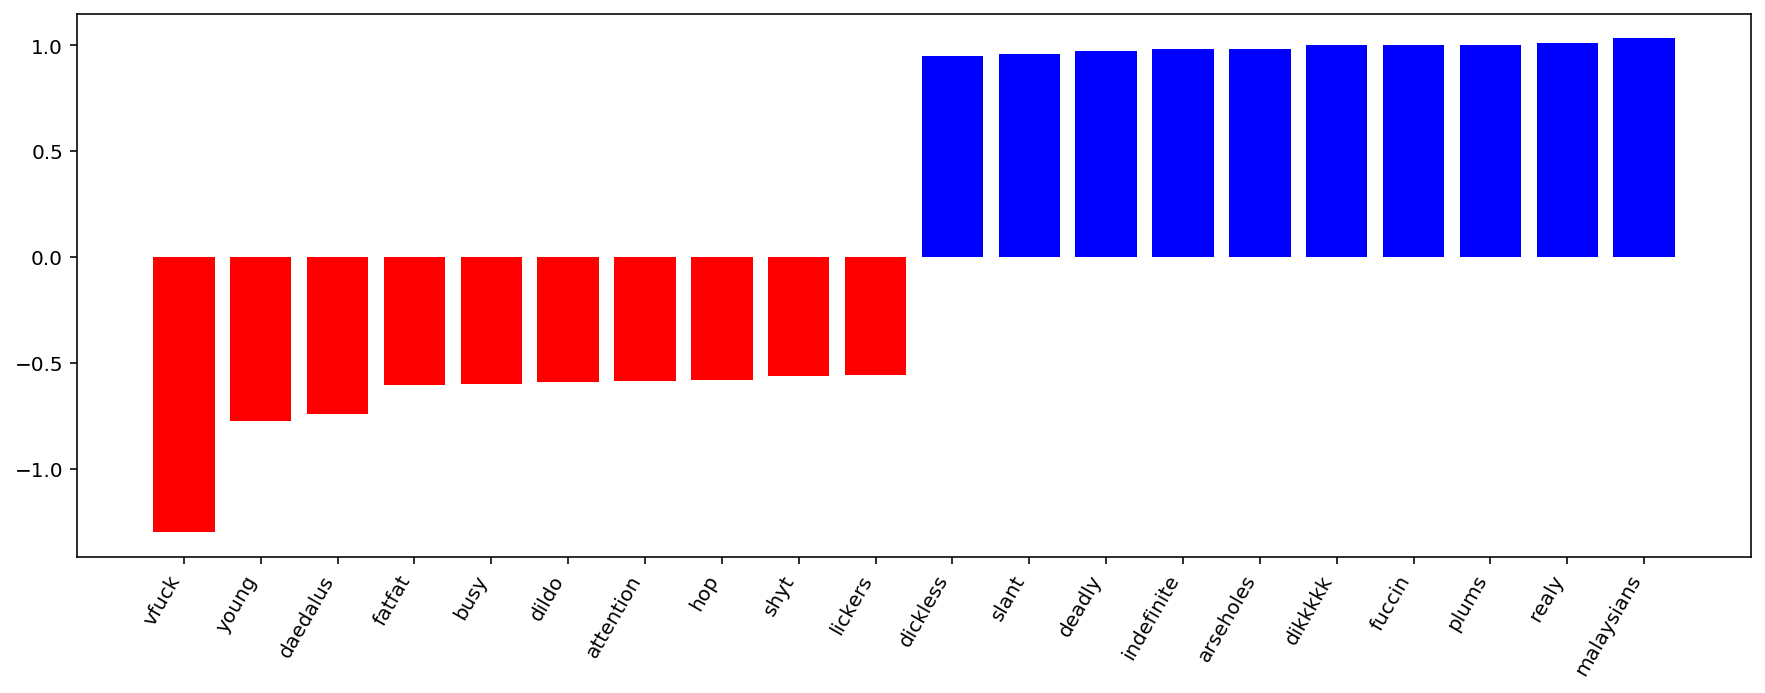

	... Processing obscene
	Training...


array([[1631,  390],
       [ 495, 1761]])

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2021
           1       0.82      0.78      0.80      2256

    accuracy                           0.79      4277
   macro avg       0.79      0.79      0.79      4277
weighted avg       0.79      0.79      0.79      4277



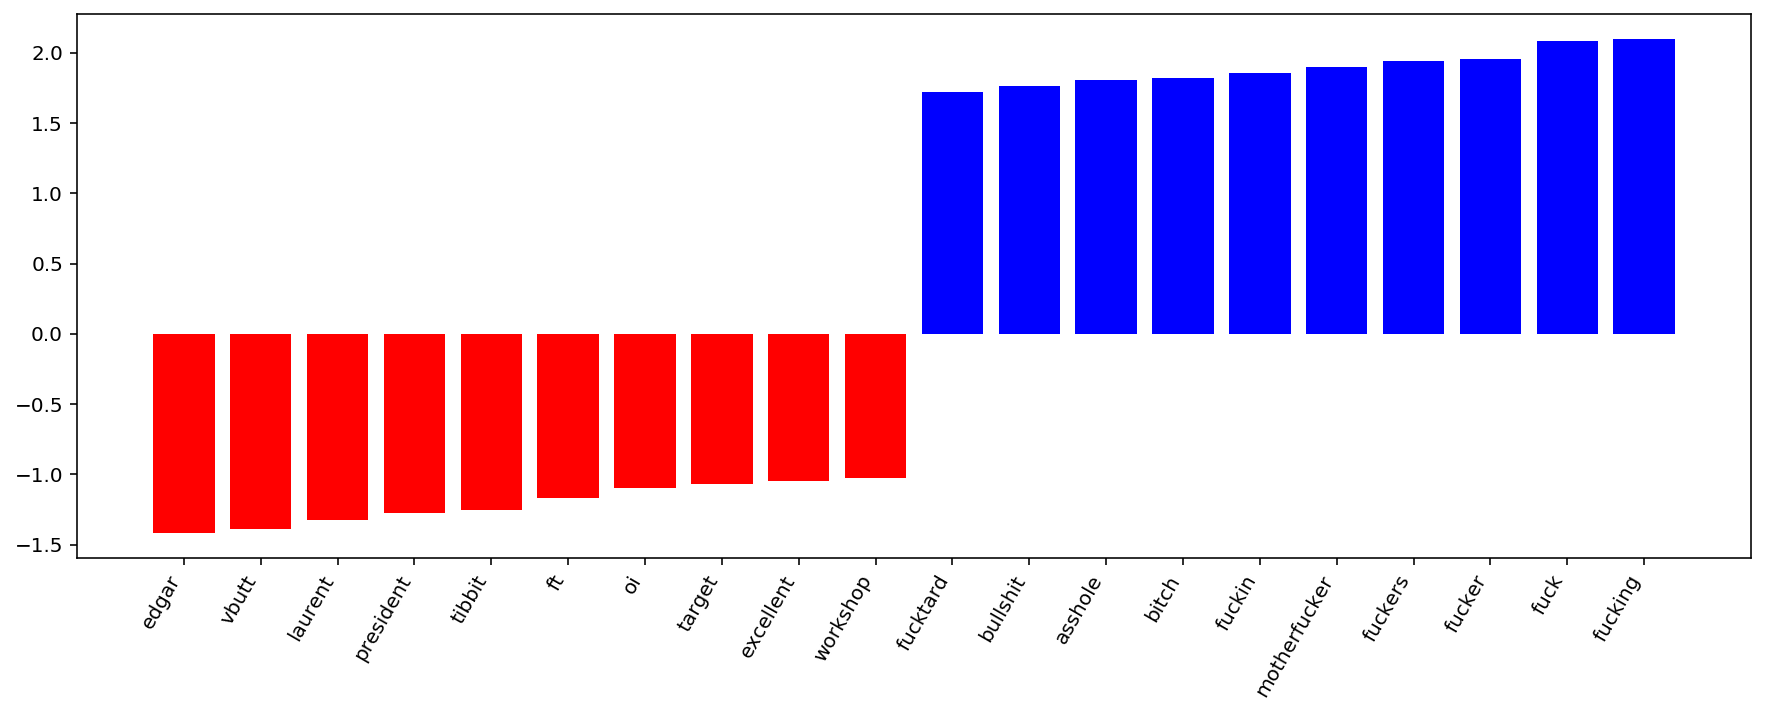

	... Processing threat
	Training...


array([[4113,   47],
       [  80,   37]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4160
           1       0.44      0.32      0.37       117

    accuracy                           0.97      4277
   macro avg       0.71      0.65      0.68      4277
weighted avg       0.97      0.97      0.97      4277



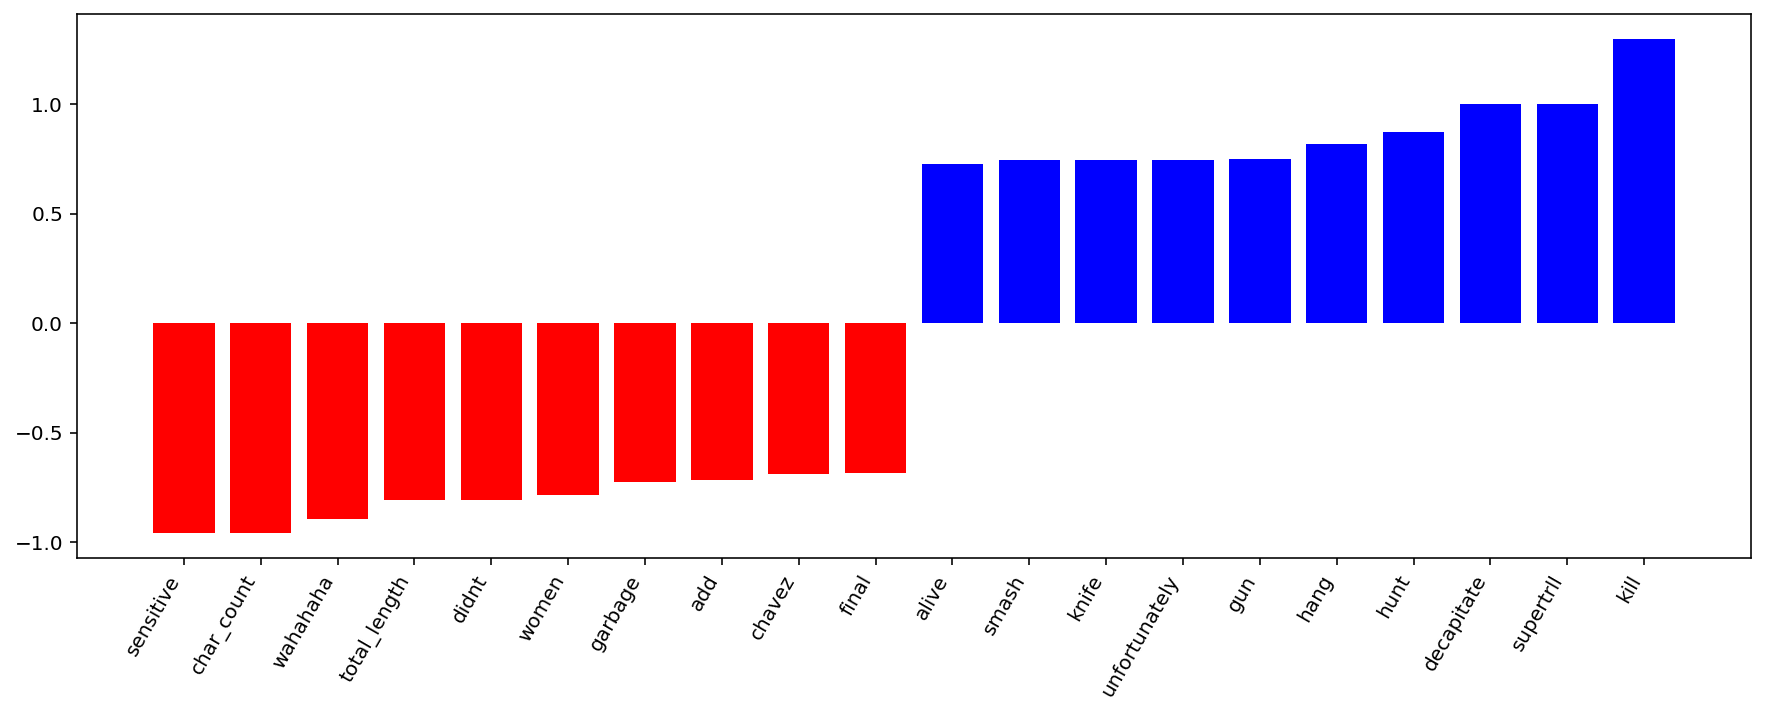

	... Processing insult
	Training...


array([[1507,  652],
       [ 743, 1375]])

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      2159
           1       0.68      0.65      0.66      2118

    accuracy                           0.67      4277
   macro avg       0.67      0.67      0.67      4277
weighted avg       0.67      0.67      0.67      4277



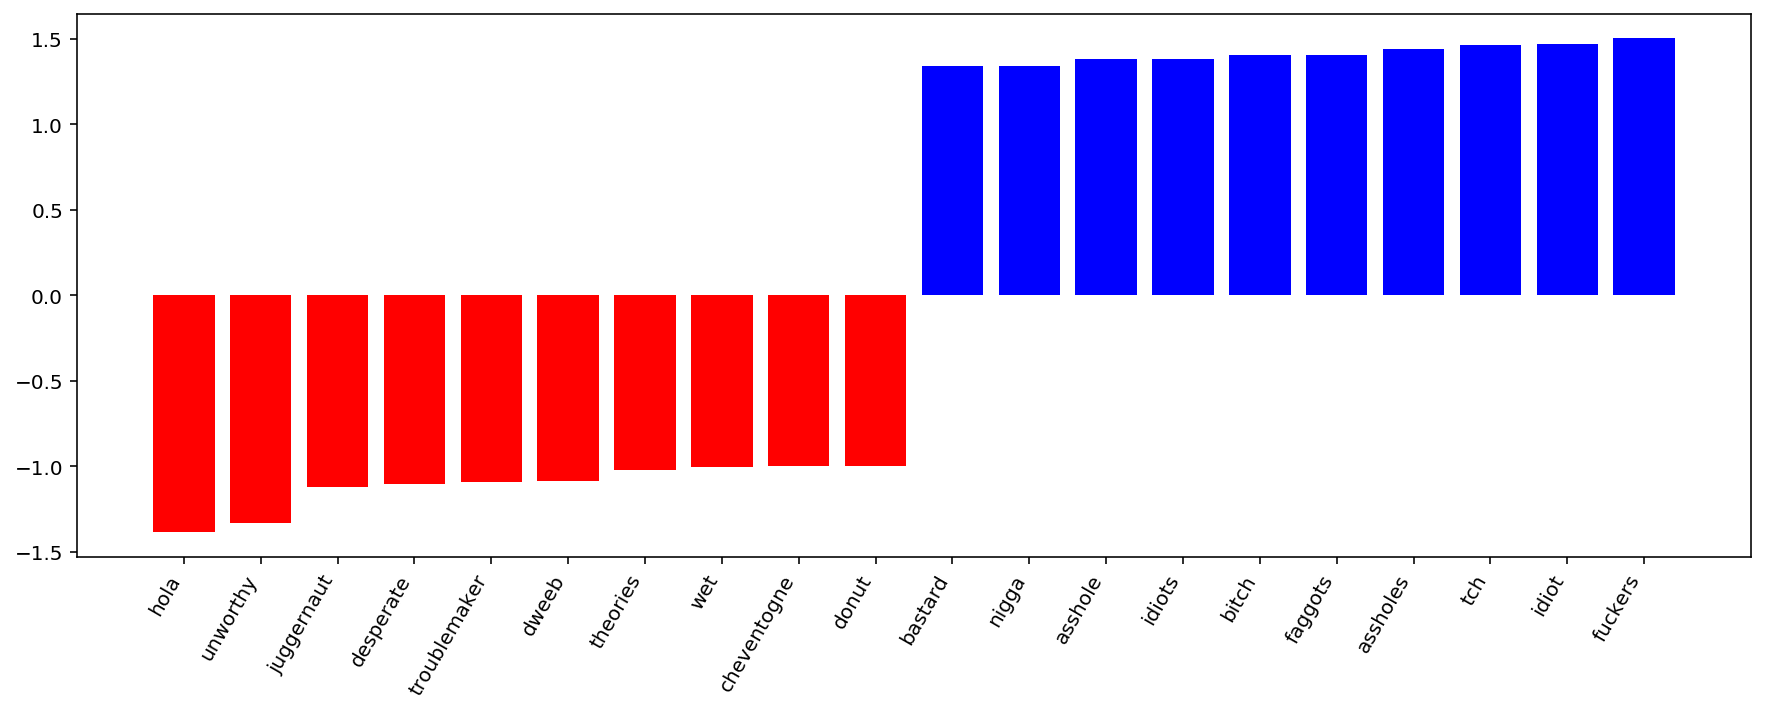

	... Processing identity_hate
	Training...


array([[3788,  106],
       [ 265,  118]])

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3894
           1       0.53      0.31      0.39       383

    accuracy                           0.91      4277
   macro avg       0.73      0.64      0.67      4277
weighted avg       0.90      0.91      0.90      4277



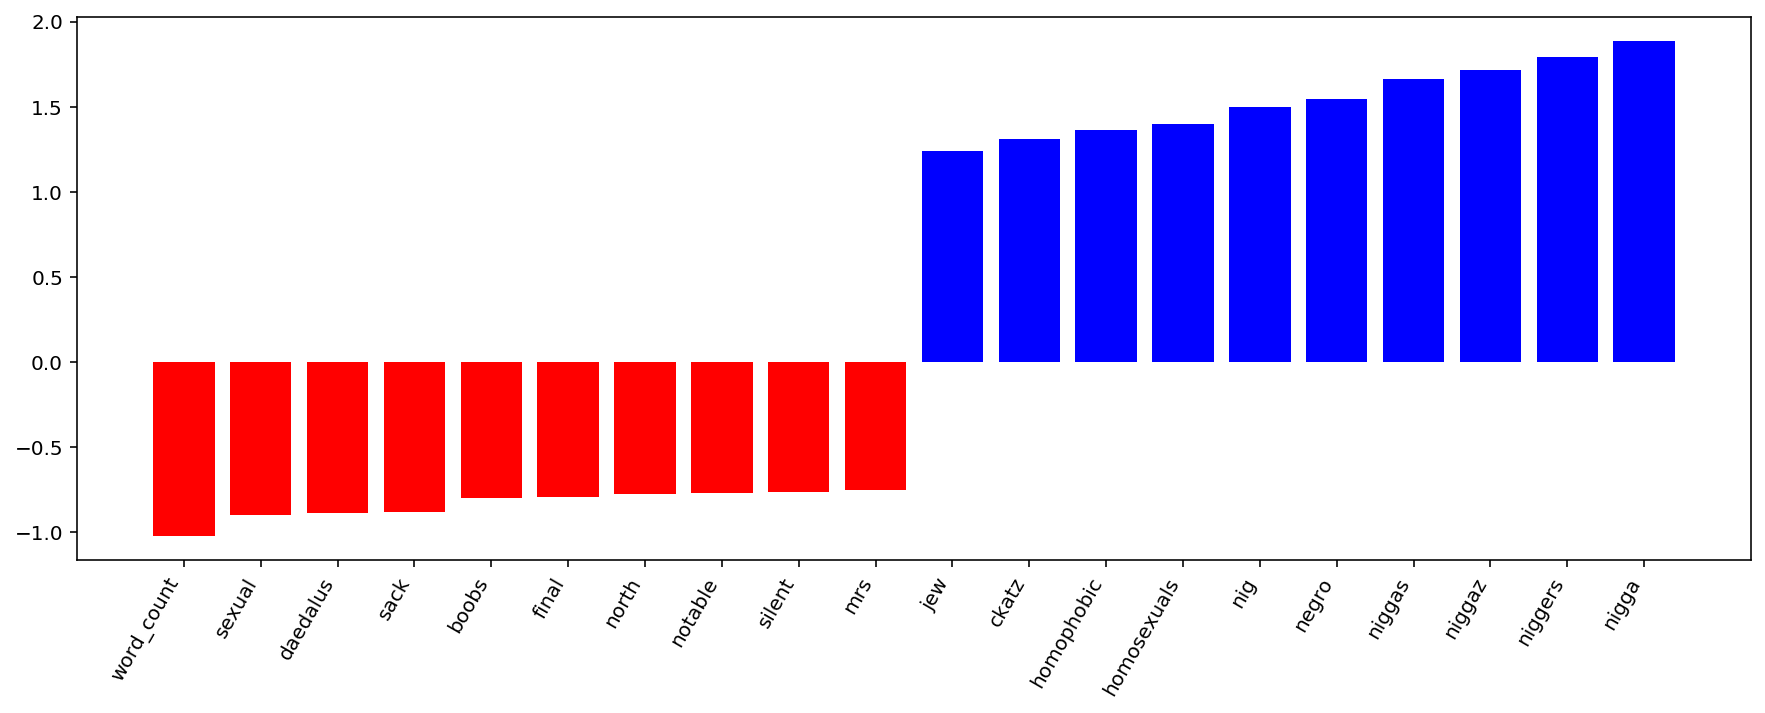


Micro Precision: 72.36%
Micro Recall: 63.62%
Micro F1-score: 67.71%
Average Accuracy: 85.05%


In [17]:
print('Calculating for C = 0.5')

test_TP = list()
test_FP = list()
test_FN = list()
test_TN = list()
test_accuracy = list()
test_precision = list()
test_recall = list()
test_f1_score = list()

for category in categories:
    print('\t... Processing {}'.format(category))

    # train the model
    print('\tTraining...')
    pipelines[1].fit(X_train, y_train[category])
    test_pred = pipelines[1].predict(X_test)

    display(confusion_matrix(y_test[category], test_pred))
    print(classification_report(y_test[category], test_pred))
    
    cm = confusion_matrix(y_test[category], test_pred)
    TN_i = cm[0][0]
    FP_i = cm[0][1]
    FN_i = cm[1][0]
    TP_i = cm[1][1]

    test_TP.append(TP_i)
    test_FP.append(FP_i)
    test_FN.append(FN_i)
    test_TN.append(TN_i)

    accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
    test_accuracy.append(accuracy_i)
    
    # feature importance
    feature_importances = Get_Feature_Importances(pipelines[1])
    Plot_Feature_Importances(feature_importances) 
    
    # saving the model
    filename = 'Count_SVM_Level_2_' + str(category) + '.joblib'
    joblib.dump(pipelines[1], filename)

test_avg_accuracy = np.average(test_accuracy)
test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)

print("\nMicro Precision: {}%".format(round(100*test_precision, 2)))
print("Micro Recall: {}%".format(round(100*test_recall, 2)))
print("Micro F1-score: {}%".format(round(100*test_f1_score, 2)))
print("Average Accuracy: {}%".format(round(100*test_avg_accuracy, 2)))